<a href="https://colab.research.google.com/github/H40Q1/523_stock_predict/blob/main/parameters_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np # linear algebra
import random
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable

In [ ]:
import os
for dirname, _, filenames in os.walk('drive/Shareddrives/523project/Dataset/Kaggle_dataset/'):
    for i, filename in enumerate(filenames):
        if i<5:
            print(os.path.join(dirname,filename))

drive/Shareddrives/523project/Dataset/Kaggle_dataset/aapl.us.txt
drive/Shareddrives/523project/Dataset/Kaggle_dataset/amzn.us.txt
drive/Shareddrives/523project/Dataset/Kaggle_dataset/fb.us.txt
drive/Shareddrives/523project/Dataset/Kaggle_dataset/msft.us.txt
drive/Shareddrives/523project/Dataset/Kaggle_dataset/SHA.cn.txt


# Visualize training data

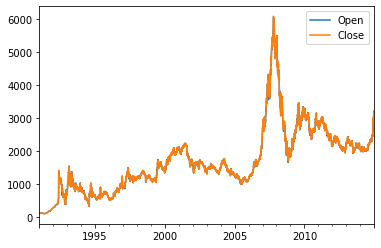

In [ ]:
def stocks_data(symbols, dates):
    df = pd.DataFrame(index=dates)
    for symbol in symbols:
        df_temp = pd.read_csv("drive/Shareddrives/523project/Dataset/Kaggle_dataset/{}.txt".format(symbol), index_col='Date',
                parse_dates=True, usecols=['Date', 'Close','Open'], na_values=['nan'])
        # df_temp = df_temp.rename(columns={'Close': symbol})
        df = df.join(df_temp)
    return df

dates = pd.date_range('1991-01-02','2014-12-31',freq='B')
symbols=['SHA.cn']
df = stocks_data(symbols, dates)
df.fillna(method='pad')
df.interpolate().plot()
plt.title('')
plt.show()

# Configure 

In [ ]:

class Config:
    #################################################################################
    # trainning dataset parameters

    #[Date,Open,High,Low,Close,Volume,OpenInt]

    stock = 'SHA.cn'     # stock need to be Train

    feature_columns = ['Close']    # fields to train model 

    label_columns = ['Close']      # predicted feature columns

    date_range = ['1991-01-02','2014-12-31']  # choose date range from stock file

    label_in_feature_index = (lambda x,y: [x.index(i) for i in y])(feature_columns, label_columns)  

    predict_day = 1             # predited length (days)

    time_step = 20              # step size (day)

    train_data_rate = 0.7      
    valid_data_rate = 0.15   
    test_data_rate = 0.15

    batch_size = 4000
    #####################################################################################################
    # model parameters
    epoch = 100

    learning_rate = 0.001

    hidden_size = 32          # hiddent size

    lstm_layers = 2             # stacked layer number

    dropout_rate = 1          # dropout

    use_cuda = True

    input_size = (batch_size, time_step-1, len(feature_columns))
    
    # path
    used_frame = "pytorch"
    model_name = "model_" + ".pth"
    train_data_path = "drive/Shareddrives/523project/Dataset/Kaggle_dataset/" +stock+ ".txt"
    model_save_path = "drive/Shareddrives/523project/Model/checkpoint/" + used_frame + "/"


    # save 
    if not os.path.exists(model_save_path):
        os.makedirs(model_save_path) 


# Data preprocessing class

In [ ]:

class Data:
    def __init__(self, config):
        self.time_step = config.time_step
        self.train_data_rate = config.train_data_rate
        self.valid_data_rate = config.valid_data_rate
        self.test_data_rate = config.test_data_rate

        self.x_cols = config.feature_columns
        self.y_cols = config.label_columns
        
        self.train_data_path = config.train_data_path
        self.date_range = config.date_range
        
        self.scaler ={}
        for col  in config.feature_columns:
            self.scaler[col] = MinMaxScaler(feature_range=(-1, 1))
        
        self.batch_size = config.batch_size


    def load_data(self, plot=False):
        stock, label_indexs = self.stocks_data(plot)
        # print(stock.head())

        stock = stock.fillna(method='ffill')

        for key in self.x_cols:
            stock[key] = self.scaler[key].fit_transform(np.array(stock[key]).reshape(-1,1))
        
        data_raw = stock.values
        data = []

        # create all possible sequences of length seq_len
        for index in range(len(data_raw) - self.time_step): 
            data.append(data_raw[index: index + self.time_step])
        
        data = np.array(data)
        train_set_size = int(np.round(self.train_data_rate*data.shape[0]))
        valid_set_size = int(np.round(self.valid_data_rate*data.shape[0]))
        test_set_size = data.shape[0] - (train_set_size+valid_set_size)
        

        x_train = data[:train_set_size,:-1,:]
        y_train = data[:train_set_size,-1,label_indexs].reshape(-1,len(self.y_cols))

        x_valid = data[train_set_size:train_set_size+valid_set_size, : -1,: ]
        y_valid = data[train_set_size:train_set_size+valid_set_size, -1,label_indexs].reshape(-1,len(self.y_cols))
        
        x_test = data[train_set_size+valid_set_size:,:-1,:]
        y_test = data[train_set_size+valid_set_size:,-1,label_indexs].reshape(-1,len(self.y_cols))

        x_train = torch.from_numpy(x_train).type(torch.Tensor)
        x_test = torch.from_numpy(x_test).type(torch.Tensor)

        x_valid = torch.from_numpy(x_valid).type(torch.Tensor)
        y_valid = torch.from_numpy(y_valid).type(torch.Tensor)

        y_train = torch.from_numpy(y_train).type(torch.Tensor)
        y_test = torch.from_numpy(y_test).type(torch.Tensor)
        
        return [x_train, y_train,x_valid, y_valid, x_test, y_test]

    def stocks_data(self, plot=False):
        dates = pd.date_range(self.date_range[0],self.date_range[1],freq='B')
        df = pd.DataFrame(index=dates)
        df_temp = pd.read_csv(self.train_data_path, index_col='Date',
                parse_dates=True, usecols=self.x_cols +['Date'], na_values=['nan'])
        df = df.join(df_temp)

        # update x_cols for real order
        self.x_cols = df.columns.tolist()

        df.fillna(method='pad')
        label_indexs =[]
        for i in self.x_cols:
            if i in self.y_cols:
                label_indexs.append(df.columns.get_loc(i))
        if plot:   
            df.interpolate().plot()
            plt.show()

        # update y_col for real order
        self.y_cols = [self.x_cols[i] for i in label_indexs]

        return df, label_indexs

    def data_loader(self,x_train, y_train,x_valid, y_valid, x_test, y_test):
        train = torch.utils.data.TensorDataset(x_train,y_train)
        valid = torch.utils.data.TensorDataset(x_valid,y_valid)
        test = torch.utils.data.TensorDataset(x_test,y_test)

        train_loader = torch.utils.data.DataLoader(dataset=train, 
                                                batch_size=self.batch_size, 
                                                shuffle=False)

        valid_loader = torch.utils.data.DataLoader(dataset=valid, 
                                                batch_size=self.batch_size, 
                                                shuffle=False)

        test_loader = torch.utils.data.DataLoader(dataset=test, 
                                                batch_size=self.batch_size, 
                                                shuffle=False)
        return train_loader, valid_loader, test_loader


# LSTM class

In [ ]:
class LSTM(nn.Module):
    def __init__(self,config):
        super(LSTM, self).__init__()
        self.input_dim = len(config.feature_columns)
        self.hidden_dim = config.hidden_size
        self.num_layers = config.lstm_layers
        self.output_dim = len(config.label_columns)

        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers, batch_first=True)
        self.fc = nn.Linear(self.hidden_dim, self.output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

# Train 

In [ ]:
def train(net ,train_loader, valid_loader, config, criterion, optimizer, log):
    if log:
      print("Start training ...")
    # device = torch.device("cuda:0" if config.use_cuda and torch.cuda.is_available() else "cpu")
    device = torch.device('cpu')
    net.to(device)

    losses = []  # store losses of each iteration
    epc_mean = []  # store mean losses of each epoch
    valid_losses =[]
    valid_epoch_mean=[]
    for epoch in range(config.epoch):
        epoch_loss = []
        valid_epoch_loss=[]
        for i, data in enumerate(train_loader):
            train_x, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            y_pred = net(train_x)
            loss = criterion(y_pred, labels)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            # validation loss 
            epoch_loss.append(loss.item())

        for v_i, v_data in enumerate(valid_loader):
            valid_x, v_labels = v_data[0].to(device), v_data[1].to(device)
            valid_y_pred = net(valid_x)
            valid_loss = criterion(y_pred, labels)
            valid_losses.append(valid_loss.item())
            valid_epoch_loss.append(valid_loss.item())

        cur_loss = np.mean(np.array(epoch_loss))
        valid_cur_loss = np.mean(np.array( valid_epoch_loss))
        if (epoch+1)% 10 == 0 and epoch!=0 and log:
          print("Epoch {}/{}".format(epoch+1, config.epoch), " Train Loss :{}".format(cur_loss)," validation Loss :{}".format(valid_cur_loss))
        epc_mean.append(cur_loss)
        valid_epoch_mean.append(valid_cur_loss)
        
    
    torch.save(net.state_dict(), config.model_save_path + config.model_name)
    if log:
      print('Finished Training Trainset')
      print('Net parameters are saved at {}'.format(config.model_save_path + config.model_name))
    return losses, epc_mean, valid_losses, valid_epoch_mean


# RMSE

In [ ]:

def evaluation(model, scaler, y_labels,  x_train, y_train,  x_test, y_test, x_valid, y_valid ):
    # make predictions
    y_test_pred = model(x_test)
    y_train_pred = model(x_train)
    y_valid_pred = model(x_valid)

    y_train_pred_inv = np.zeros(y_train.shape )
    y_train_inv = np.zeros(y_train.shape )
  
    y_test_pred_inv = np.zeros(y_test.shape )
    y_test_inv = np.zeros(y_test.shape )

    y_valid_pred_inv = np.zeros(y_valid.shape )
    y_valid_inv = np.zeros(y_valid.shape )
    

    # invert predictions
    for i , label in enumerate(y_labels): 
        y_train_pred_inv[:,i] = list( scaler[label].inverse_transform(y_train_pred.detach().numpy()[:,i].reshape(-1,1)) )
        y_train_inv[:,i] = list( scaler[label].inverse_transform(y_train.detach().numpy()[:,i].reshape(-1,1)) )

        y_test_pred_inv[:,i] = list( scaler[label].inverse_transform(y_test_pred.detach().numpy()[:,i].reshape(-1,1)) )
        y_test_inv[:,i] = list (scaler[label].inverse_transform(y_test.detach().numpy()[:,i].reshape(-1,1)) )

        y_valid_pred_inv[:,i] = list( scaler[label].inverse_transform(y_valid_pred.detach().numpy()[:,i].reshape(-1,1)) )
        y_valid_inv[:,i] = list (scaler[label].inverse_transform(y_valid.detach().numpy()[:,i].reshape(-1,1)) )

    # calculate root mean squared error
    # trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))

    trainScore = math.sqrt(mean_squared_error(y_train_inv,y_train_pred_inv))

    validScore = math.sqrt(mean_squared_error(y_valid_inv,y_valid_pred_inv))

    testScore = math.sqrt(mean_squared_error(y_test_inv, y_test_pred_inv))

    return trainScore, validScore, testScore


# Model Summary

In [ ]:
def model_summary(model):
  print("model_summary")
  print()
  print("Layer_name"+"\t"*7+"Number of Parameters")
  print("="*100)
  model_parameters = [layer for layer in model.parameters() if layer.requires_grad]
  layer_name = [child for child in model.children()]
  j = 0
  total_params = 0
  print("\t"*10)
  for i in layer_name:
    print()
    param = 0
    try:
      bias = (i.bias is not None)
    except:
      bias = False  
    if not bias:
      param =model_parameters[j].numel()+model_parameters[j+1].numel()
      j = j+2
    else:
      param =model_parameters[j].numel()
      j = j+1
    print(str(i)+"\t"*3+str(param))
    total_params+=param
  print("="*100)
  print(f"Total Params:{total_params}")


In [ ]:
def Summary(df, losses, valid_losses, config, net, trainScore, validScore, testScore):

    df.head()
    df.interpolate().plot()
    plt.show()

    model_summary(net)

    # parameter
    print('Test Score: %.2f RMSE' % (testScore))
    print('valid Score: %.2f RMSE' % (validScore))
    print('Train Score: %.2f RMSE' % (trainScore))

    plt.plot(losses, c='b', label='training') 
    plt.plot(valid_losses, c='r', label='valid')
    plt.legend() 
    plt.xlabel('epoch') 
    plt.ylabel('training loss') 

    plt.title('Training Loss history for '+ config.stock +'stock ') 
    plt.show()


# Default config training

In [ ]:
def Tune_parameters(config, summary = True, log=True):
  data = Data(config)
  df,_ =data.stocks_data()
  x_train, y_train,x_valid, y_valid, x_test, y_test = data.load_data(plot=False)
  train_loader, valid_loader, test_loader = data.data_loader(x_train, y_train,x_valid, y_valid, x_test, y_test)
  net = LSTM(config)
  criterion = torch.nn.MSELoss(size_average=True)
  optimizer = torch.optim.Adam(net.parameters(), lr=config.learning_rate)
  losses, epc_mean, valid_losses, valid_epoch_mean = train(net, train_loader, valid_loader, config, criterion, optimizer, log)
  trainScore, validScore, testScore = evaluation(net, data.scaler, data.y_cols, x_train, y_train,  x_test, y_test, x_valid, y_valid )
  
  if summary:
    Summary(df, epc_mean, valid_epoch_mean, config, net,trainScore, validScore, testScore)
  return trainScore, validScore, testScore


In [ ]:
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Start training ...
Epoch 10/100  Train Loss :0.3117845058441162  validation Loss :0.1716327667236328
Epoch 20/100  Train Loss :0.1050914884544909  validation Loss :0.19776031374931335
Epoch 30/100  Train Loss :0.031646443996578455  validation Loss :0.06081308797001839
Epoch 40/100  Train Loss :0.012569486687425524  validation Loss :0.023305905982851982
Epoch 50/100  Train Loss :0.006155080802273005  validation Loss :0.010993934236466885
Epoch 60/100  Train Loss :0.003716341045219451  validation Loss :0.00555147510021925
Epoch 70/100  Train Loss :0.002686751598957926  validation Loss :0.003668850986286998
Epoch 80/100  Train Loss :0.0019331428338773549  validation Loss :0.0027791233733296394
Epoch 90/100  Train Loss :0.0014732845302205533  validation Loss :0.002194852102547884
Epoch 100/100  Train Loss :0.001222607446834445  validation Loss :0.0018497304990887642
Finished Training Trainset
Net parameters are saved at drive/Shareddrives/523project/Model/checkpoint/pytorch/model_.pth


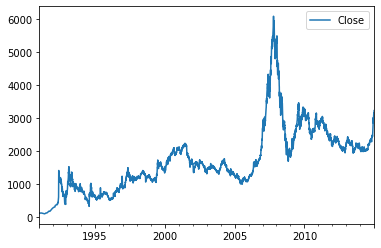

model_summary

Layer_name							Number of Parameters
										

LSTM(1, 32, num_layers=2, batch_first=True)			128

Linear(in_features=32, out_features=1, bias=True)			4096
Total Params:4224
Test Score: 78.29 RMSE
valid Score: 191.23 RMSE
Train Score: 78.65 RMSE


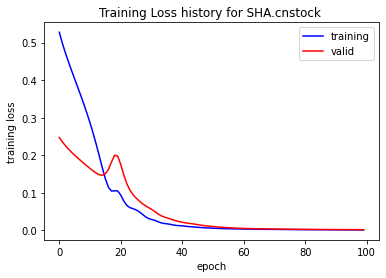

(78.65194700605338, 191.2333584042861, 78.2853680337509)

In [ ]:
config = Config()
Tune_parameters(config)

# Batch Size 

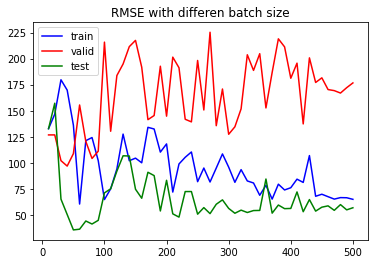

In [ ]:
config= Config
batch_size = [i*10 for i in range(1, 51)]
trainScores =[]
validScores =[]
testScores = []

for b in batch_size:
  config.batch_size = b
  trainScore, validScore, testScore = Tune_parameters(config, summary= False,log=False)
  trainScores.append(trainScore)
  validScores.append(validScore)
  testScores.append(testScore)
plt.plot(batch_size,trainScores, c='b', label ='train' )
plt.plot(batch_size,validScores, c='r', label ='valid' )
plt.plot(batch_size,testScores, c='g', label ='test' )
plt.legend()
plt.title('RMSE with differen batch size')
plt.show()

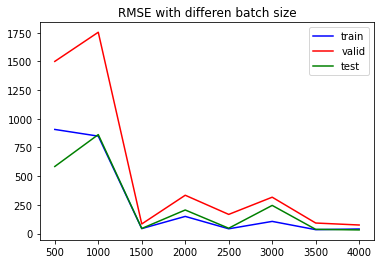

In [ ]:
config= Config
batch_size = [i*500 for i in range(1, 9)]
trainScores =[]
validScores =[]
testScores = []

for b in batch_size:
  config.batch_size = b
  trainScore, validScore, testScore = Tune_parameters(config, summary= False,log=False)
  trainScores.append(trainScore)
  validScores.append(validScore)
  testScores.append(testScore)
plt.plot(batch_size,trainScores, c='b', label ='train' )
plt.plot(batch_size,validScores, c='r', label ='valid' )
plt.plot(batch_size,testScores, c='g', label ='test' )
plt.legend()
plt.title('RMSE with differen batch size')
plt.show()

# Learning Rate

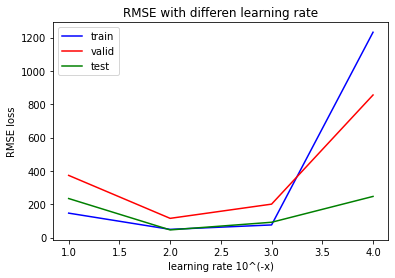

In [ ]:
config= Config
learning_rate = [0.0001, 0.001, 0.01, 0.1]
trainScores =[]
validScores =[]
testScores = []
x = [4,3,2,1]
for lr in learning_rate:
  config.learning_rate = lr
  trainScore, validScore, testScore = Tune_parameters(config, summary= False,log=False)
  trainScores.append(trainScore)
  validScores.append(validScore)
  testScores.append(testScore)
plt.plot(x,trainScores, c='b', label ='train' )
plt.plot(x,validScores, c='r', label ='valid' )
plt.plot(x,testScores, c='g', label ='test' )
plt.legend()
plt.xlabel('learning rate 10^(-x)')
plt.ylabel('RMSE loss')
plt.title('RMSE with differen learning rate')
plt.show()

# Features 

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.for

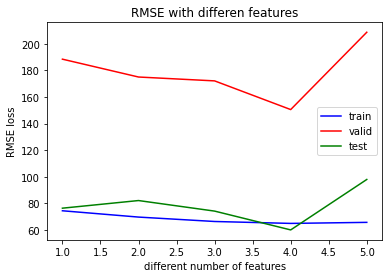

In [ ]:
config = Config()
feature_columns = [
         ['Close'],
         ['Close', 'Open'],
         ['Close', 'Open', 'Low'],
         ['Close', 'Open', 'Low', 'High'],
         ['Close', 'Open', 'Low', 'High', 'Volume'],
]
trainScores =[]
validScores =[]
testScores = []
x = [1,2,3,4,5]
for fs in feature_columns:
  config.feature_columns = fs
  trainScore, validScore, testScore = Tune_parameters(config, summary= False,log=False)
  trainScores.append(trainScore)
  validScores.append(validScore)
  testScores.append(testScore)
plt.plot(x,trainScores, c='b', label ='train' )
plt.plot(x,validScores, c='r', label ='valid' )
plt.plot(x,testScores, c='g', label ='test' )
plt.legend()
plt.xlabel('different number of features')
plt.ylabel('RMSE loss')
plt.title('RMSE with differen features')
plt.show()

# Best parameter LSTM

Start training ...
Epoch 10/100  Train Loss :0.020699418149888515  validation Loss :0.027584180235862732
Epoch 20/100  Train Loss :0.0027776992064900696  validation Loss :0.004102571867406368
Epoch 30/100  Train Loss :0.0008567684126319364  validation Loss :0.0013155258493497968
Epoch 40/100  Train Loss :0.0005992480073473416  validation Loss :0.0009734365739859641
Epoch 50/100  Train Loss :0.0005752197757828981  validation Loss :0.0009431943763047457
Epoch 60/100  Train Loss :0.0005655327695421875  validation Loss :0.0009305058629252017
Epoch 70/100  Train Loss :0.0005564848979702219  validation Loss :0.0009167591924779117
Epoch 80/100  Train Loss :0.0005477703816723078  validation Loss :0.0009033138630911708
Epoch 90/100  Train Loss :0.0005389135039877146  validation Loss :0.0008892210316844285
Epoch 100/100  Train Loss :0.000529920267581474  validation Loss :0.0008745919330976903
Finished Training Trainset
Net parameters are saved at drive/Shareddrives/523project/Model/checkpoint/py

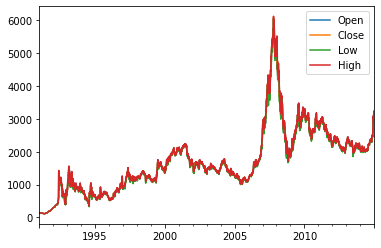

model_summary

Layer_name							Number of Parameters
										

LSTM(4, 32, num_layers=2, batch_first=True)			512

Linear(in_features=32, out_features=1, bias=True)			4096
Total Params:4608
Test Score: 42.01 RMSE
valid Score: 98.32 RMSE
Train Score: 46.67 RMSE


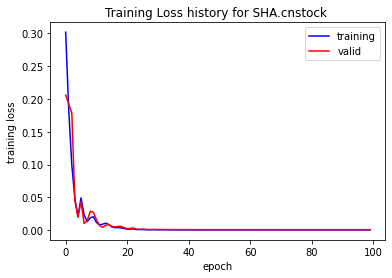

(46.667863714117324, 98.32049807987548, 42.011036361890575)

In [ ]:
config = Config()
config.learning_rate = 0.01
config.feature_columns = ['Close', 'Open', 'Low', 'High']
config.batch_size = 4000
#config.epoch= 
# config.time_step =
# config.hidden_size = 
# config.dropout_rate =
# config.lstm_layers=

Tune_parameters(config)